In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

In [4]:
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7) # Prep data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12,)
(6,)
(12,)
(6,)


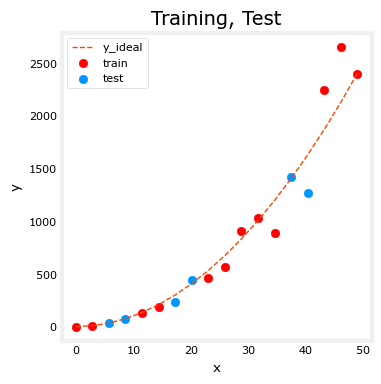

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plotting ideal curve
ax.plot(x_ideal, y_ideal, "--", color="orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Plotting training and testing points
ax.scatter(X_train, y_train, color="red", label="train")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc="upper left")
plt.show()

In [6]:
# Mean Squared Error Function
def MSE(y, yhat):
    m = len(y)
    err = 0.0
    for i in range(m):
        err += (y[i] - yhat[i])**2
    err /= 2*m
    return err

In [7]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
MSE(y_hat, y_tmp)

test_eval_mse(MSE)

 All tests passed.


In [8]:
# Create a high degree polynomial model to check performance
# Some of this is imported from utils.py

deg = 10 # Set current degrees to 10 - Very high
lmodel = lin_model(deg)
lmodel.fit(X_train, y_train)

# make predictions on train dataset
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# make predictions on test dataset
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [9]:
print(f"Training error: {err_train}") # This number is low
print(f"Training test: {err_test}") # This number is extremely high

Training error: 58.007560581461014
Training test: 171215.01175908983


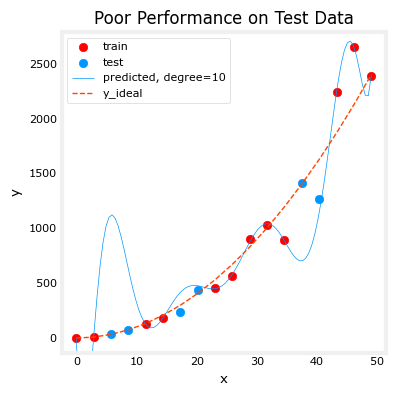

In [10]:
x = np.linspace(0, int(X.max()), 100) # start, stop, # of points
y_pred = lmodel.predict(x).reshape(-1,1)
plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, deg)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [11]:
# Prep train, cross validate, test data sets
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(24,) (24,)
(8,) (8,)
(8,) (8,)


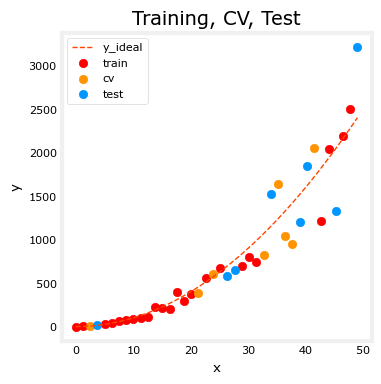

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plotting ideal curve
ax.plot(x_ideal, y_ideal, "--", color="orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Plotting training and testing points
ax.scatter(X_train, y_train, color="red", label="train")
ax.scatter(X_cv, y_cv, color=dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc="upper left")
plt.show()

In [13]:
max_deg = 9
err_train = np.zeros(max_deg)
err_cv = np.zeros(max_deg)
degs = np.zeros(max_deg)

x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_deg))

for deg in range (max_deg):
    degs[deg] = deg+1
    lmodel = lin_model(deg + 1) # Init model with certain degree
    lmodel.fit(X_train, y_train) # fit the model

    # Predict on CV dataset and save
    yhat = lmodel.predict(X_cv) 
    err_cv[deg] = lmodel.mse(y_cv, yhat)

    # Predict on Train dataset and save
    yhat = lmodel.predict(X_train)
    err_train[deg] = lmodel.mse(y_train, yhat)
    y_pred[:,deg] = lmodel.predict(x)

print(err_cv)
print(err_train)
print(degs)
# print(x)
# print(y_pred)


[ 57076.43741978  39591.78544763  42671.91459549  60706.11598541
  63952.43557854  72688.75373804 115892.49597384 129498.68401862
 140864.17623152]
[33075.06272231 10284.8696445   8414.67241515  5572.77552306
  4983.975664    4735.36600005  4008.19257457  3820.88245618
  3780.2680797 ]
[1. 2. 3. 4. 5. 6. 7. 8. 9.]


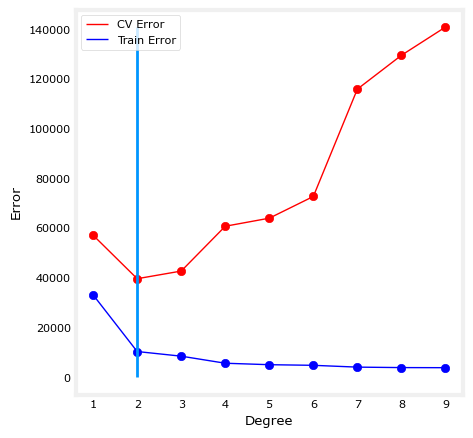

2


In [14]:
# Plotting CV and Training error
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(degs, err_cv, label="CV Error", color = "red", lw=1)
ax.plot(degs, err_train, label="Train Error", color = "blue", lw=1)
ax.scatter(degs, err_cv, color="red")
ax.scatter(degs, err_train, color="blue")

ax.plot([2, 2], [0, int(err_cv.max())], lw=2) # Optimal Degree

ax.legend(loc="upper left")
ax.set_xlabel("Degree")
ax.set_ylabel("Error")
plt.show()

print(np.argmin(err_cv) + 1)

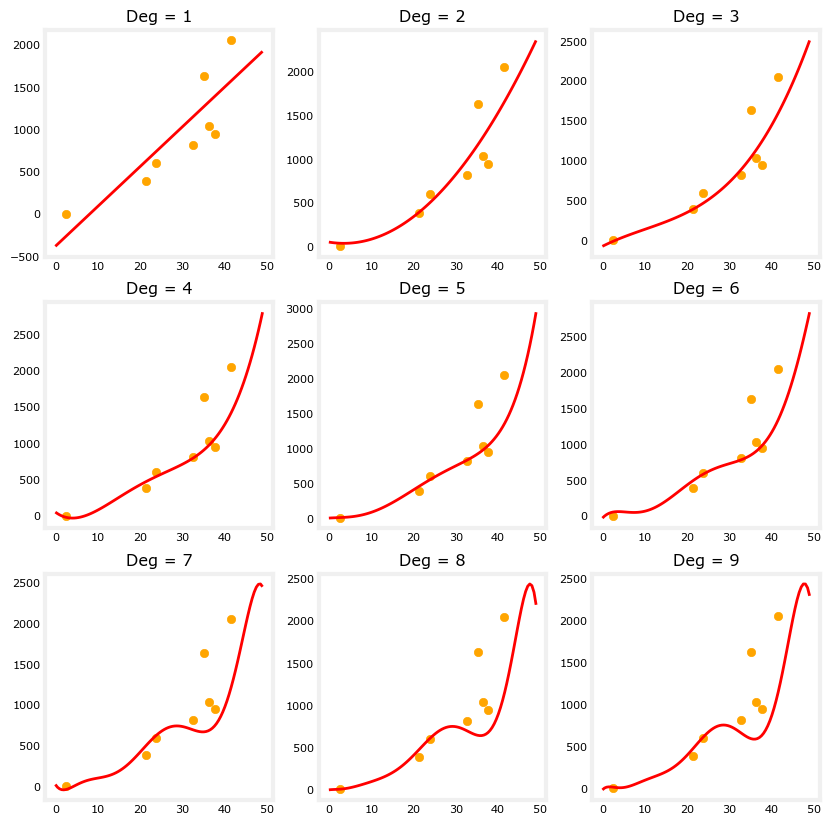

In [15]:
# Visualizing the plot for each Degree
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, axes in enumerate(ax.flat):
    axes.scatter(X_cv, y_cv, color="orange")
    axes.plot(x, y_pred[:,i], color="red", lw=2)
    axes.set_title(f"Deg = {i+1}")

<a name="3.3"></a>
### Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [16]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

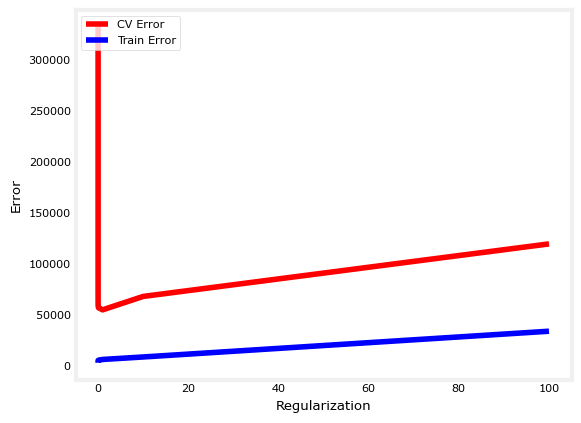

[332498.75181286 115064.08669161  98995.60983571  76072.54077306
  64245.44326597  58922.77208636  56996.5247964   54961.40869121
  68104.58886429 119626.41943768]
[ 3045.80903912  3896.86916962  4072.28488357  4506.76787532
  4962.43611929  5275.7284349   5636.86106528  6308.56666011
  8746.36455303 33994.14204341]


In [17]:
fig, ax = plt.subplots(1, 1)
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
deg, m = 10, len(lambda_range)
err_cv = np.zeros(m)
err_train = np.zeros(m)

x = np.linspace(0, int(lambda_range.max()), 100)
y_pred = np.zeros((100, m))


for i in range(m):
    lmodel = lin_model(deg, regularization=True, lambda_=lambda_range[i]) # Init model
    lmodel.fit(X_train, y_train) # Fit model

    # Make predictions
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)

    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)

    y_pred[:,i] = lmodel.predict(x)

plt.plot(lambda_range, err_cv, color = "red", label="CV Error")
plt.plot(lambda_range, err_train, color = "blue", label="Train Error")
ax.legend(loc="upper left")
ax.set_xlabel("Regularization")
ax.set_ylabel("Error")
plt.show()

print(err_cv)
print(err_train)

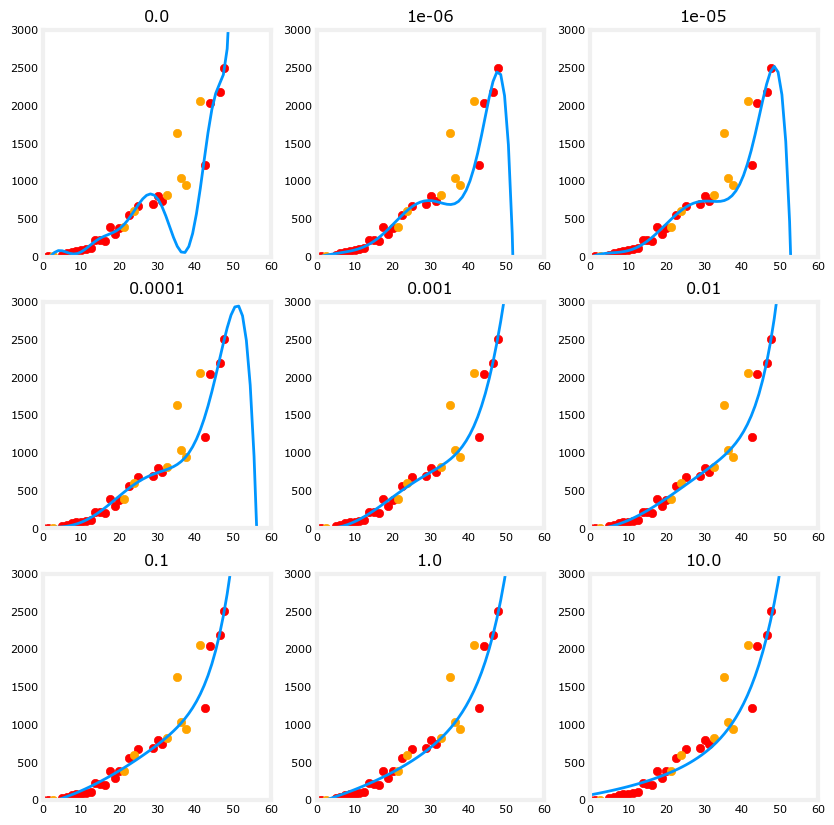

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, axes in enumerate(ax.flat):
    axes.set_title(lambda_range[i])
    axes.scatter(X_train, y_train, color="red", label="Train")
    axes.scatter(X_cv, y_cv, color="orange", label="CV")
    axes.plot(x, y_pred[:,i], lw=2)
    axes.set_ylim(0, 3000)
    axes.set_xlim(0, 60)

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

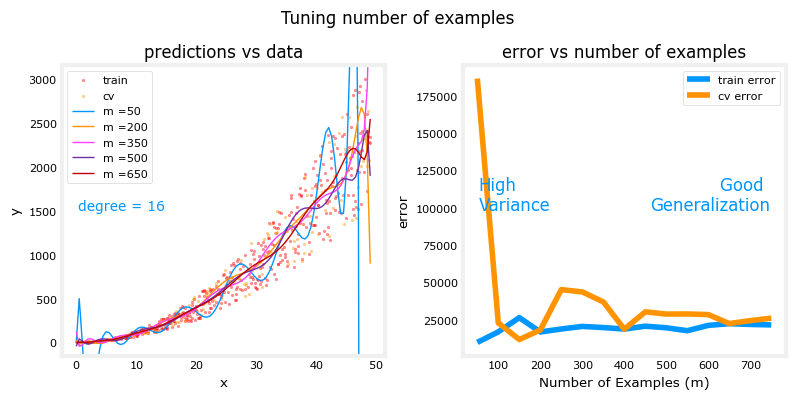

In [19]:
def plt_tune(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"m ={m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = dlc["dlblue"])

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend()
    plt.tight_layout()
    plt.show()  


X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

In [20]:
# Generate dataset
X, y, centers, classes, std = gen_blobs()

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.5, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(400, 2)
(320, 2)
(80, 2)


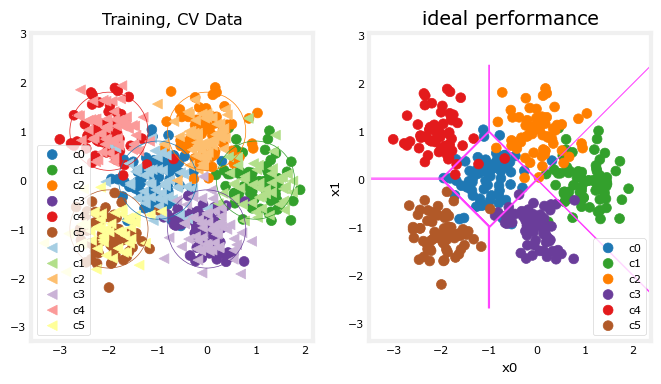

In [21]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

In [22]:
tf.random.set_seed(1234)
model = Sequential()
model.name = "Complex"
model.add(tf.keras.layers.Dense(120, activation="relu"))
model.add(tf.keras.layers.Dense(40, activation="relu"))
model.add(tf.keras.layers.Dense(6, activation="linear"))

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [23]:
model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3190
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4192 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3112 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2553 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2321 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2196 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2192 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2121 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2017 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2000 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2000 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1998 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1956 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1938  
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

In [24]:
model.summary()

Model: "Complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step


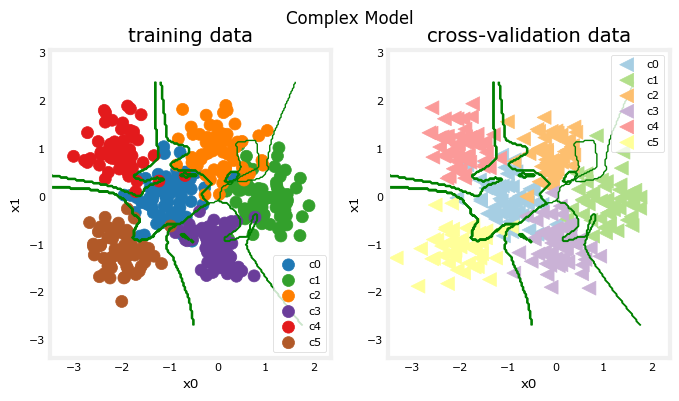

In [25]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [ ]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
categorization error, training, complex model: 0.003
categorization error, cv,       complex model: 0.106


In [28]:
# Try a simple model
tf.random.set_seed(1234)
model_s = Sequential();
model_s.add(tf.keras.layers.Dense(6, activation="relu"))
model_s.add(tf.keras.layers.Dense(6, activation="linear"))
model_s.name = "Simple"

model_s.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [29]:
model_s.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5186  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2325  
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9900 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7837 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6291 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5254 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4576 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4127 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3819 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3599 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3431 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3296 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3184 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3089 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
model_s.summary()

Model: "Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step


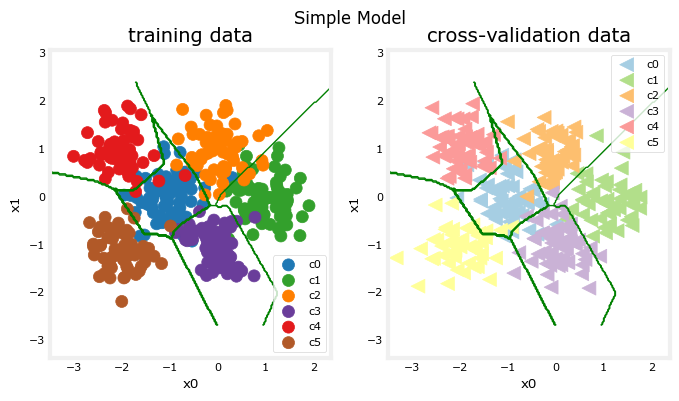

In [34]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [35]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
categorization error, training, simple model, 0.072, complex model: 0.003
categorization error, cv,       simple model, 0.078, complex model: 0.106


As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

In [ ]:
tf.random.set_seed(1234)
model_r = Sequential();
model_r.add(tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model_r.add(tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model_r.add(tf.keras.layers.Dense(6, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)))

In [44]:
tf.random.set_seed(1234)
model_r = Sequential();
model_r.add(tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model_r.add(tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model_r.add(tf.keras.layers.Dense(60, activation="linear"))

model_r.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [45]:
model_r.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.8403 
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3859 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5560 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2407 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1213 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0475 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9890 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9482 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9043 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8738 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8546 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8352 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8169 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8001 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step


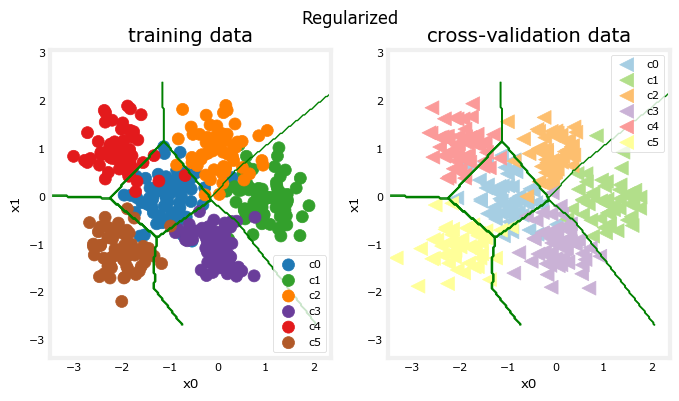

In [46]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [47]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
categorization error, training, regularized: 0.075, simple model, 0.072, complex model: 0.003
categorization error, cv,       regularized: 0.066, simple model, 0.078, complex model: 0.106


In [48]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3405
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4287 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3086 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2667 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2217 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2125 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2081 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2003 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1955 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1942 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1955 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1902 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1899 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1896 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

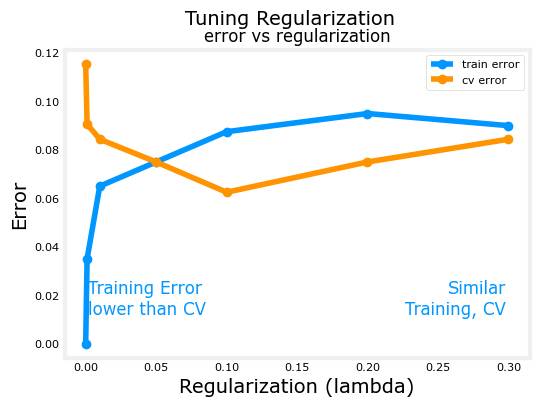

In [54]:
def plot_iter(lambdas, models, X_train, y_train, X_cv, y_cv):
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        err_train[i] = eval_cat_err(y_train,np.argmax( models[i](X_train), axis=1))
        err_cv[i] = eval_cat_err(y_cv, np.argmax( models[i](X_cv), axis=1))

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("error vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train error", color = dlc["dlblue"])
    ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = dlc["dlorange"])
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Error",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    ax.text(0.05,0.14,"Training Error\nlower than CV",fontsize=12, ha='left',transform=ax.transAxes,color = dlc["dlblue"])
    ax.text(0.95,0.14,"Similar\nTraining, CV",    fontsize=12, ha='right',transform=ax.transAxes,color = dlc["dlblue"])
    plt.show()
 

plot_iter(lambdas, models, X_train, y_train, X_cv, y_cv)